In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from HFCS_emimTF2N_PR import configuration

In [3]:
# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) 

# Add properties parameter blocks to the flowsheet with specifications
m.fs.props = GenericParameterBlock(default=configuration)

In [4]:
m.fs.F101 = Flash(default={"property_package": m.fs.props,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 8


In [5]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [6]:
# Fix Heater H101 inlet conditions
m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "emimTf2N"].fix(0.001)

m.fs.F101.inlet.flow_mol[0].fix(1)
m.fs.F101.inlet.temperature.fix(298)
m.fs.F101.inlet.pressure.fix(200000)

# Fix F101 Flash outlet conditions
m.fs.F101.vap_outlet.temperature.fix(298)
m.fs.F101.deltaP.fix(0)

DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [7]:
# m.fs.F101.initialize(outlvl=idaeslog.INFO_HIGH)

2021-03-22 16:02:35 [INFO] idaes.init.fs.F101.control_volume.properties_in: Starting initialization
2021-03-22 16:02:36 [INFO] idaes.init.fs.F101.control_volume.properties_in: Dew and bubble point initialization: optimal - Optimal Solution Found.
2021-03-22 16:02:36 [INFO] idaes.init.fs.F101.control_volume.properties_in: Equilibrium temperature initialization completed.
2021-03-22 16:02:36 [INFO] idaes.init.fs.F101.control_volume.properties_in: State variable initialization completed.
2021-03-22 16:02:37 [INFO] idaes.init.fs.F101.control_volume.properties_in: Phase equilibrium initialization: optimal - Optimal Solution Found.
2021-03-22 16:02:38 [INFO] idaes.init.fs.F101.control_volume.properties_in: Property initialization: optimal - Optimal Solution Found.
2021-03-22 16:02:38 [INFO] idaes.init.fs.F101.control_volume.properties_out: Starting initialization
2021-03-22 16:02:39 [INFO] idaes.init.fs.F101.control_volume.properties_out: Dew and bubble point initialization: optimal - Optima

In [8]:
# result = solver.solve(m, tee=True)

Ipopt 3.13.2: tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. S

In [9]:
# m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value   : Fixed : Bounds
          Heat Duty : 0.21876 : False : (None, None)
    Pressure Change :  0.0000 :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                               Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                    1.0000      0.99982     0.0011752  
    mole_frac_comp emimTf2N  0.0010000   1.0000e-08       0.85091  
    mole_frac_comp R32         0.50000      0.49997      0.096672  
    mole_frac_comp R125        0.50000      0.50003      0.052420  
    temperature                 298.00       298.00        298.00  
    pressure                2.0000e+05   2.0000e+05    2.0000e+05  


In [13]:
IL_z = [0.001,0.4,0.72,0.91,0.99]
IL_x = np.zeros((len(IL_z)))
IL_y = np.zeros((len(IL_z)))
R32_x = np.zeros((len(IL_z)))
R32_y = np.zeros((len(IL_z)))
R125_x = np.zeros((len(IL_z)))
R125_y = np.zeros((len(IL_z))) 
Z = []

#Reset kappa values to check - these are the bmimpf6 values
# m.fs.props.PR_kappa['R32', 'R125'].fix(-0.002535)
# m.fs.props.PR_kappa['R125', 'R32'].fix(-0.002535)
# # m.fs.props.PR_kappa['R32', 'bmimPF6'].fix(-0.01435)
# # m.fs.props.PR_kappa['bmimPF6', 'R32'].fix(0.9651)
# # m.fs.props.PR_kappa['bmimPF6', 'R125'].fix(0.6312)
# # m.fs.props.PR_kappa['R125', 'bmimPF6'].fix(0.0504)

# m.fs.props.PR_kappa['R32', 'emimTf2N'].fix(-0.05102)
# m.fs.props.PR_kappa['emimTf2N', 'R32'].fix(0.2839)
# m.fs.props.PR_kappa['emimTf2N', 'R125'].fix(1.6929)
# m.fs.props.PR_kappa['R125', 'emimTf2N'].fix(0.04738)

# add in second for loop for pressure
# m.fs.F101.inlet.pressure.fix(200000)
for j in range(len(IL_z)):

    fract = 1 - IL_z[j] #Think about this
    m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.3*IL_z[j])
    m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.3*fract)
    m.fs.F101.inlet.mole_frac_comp[0, "emimTf2N"].fix(0.7)   
                  
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)              

    # solve the model
    status = solver.solve(m, tee = False)
    # model.display()
    # If solution is optimal store the concentration, and calculated temperatures in the created arrays
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

        IL_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"])
        IL_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "emimTf2N"])
        R32_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
        R32_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
        R125_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
        R125_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])

        #Change this to feasible
        print(value(m.fs.F101.liq_outlet.flow_mol[0]))
        print(value(m.fs.F101.vap_outlet.flow_mol[0]))
    else:
        print('Infeasible.')

    

0.7862085879234496
0.2137914120765504
0.8111321665949937
0.18886783340500637
0.8352508587316627
0.16474914126833734
0.8523618972379269
0.1476381027620731
0.8604941783257395
0.13950582167426046


In [15]:
print("IL_x =", IL_x)
print("IL_y =", IL_y)
print("R32_x =", R32_x)
print("R32_y =", R32_y)
print("R125_x =", R125_x)
print("R125_y =", R125_y)

IL_x = [0.89034896 0.8629913  0.83807157 0.82124741 0.81348604]
IL_y = [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
R32_x = [1.61420412e-04 6.74644537e-02 1.27358576e-01 1.67060134e-01
 1.85180306e-01]
R32_y = [8.09620389e-04 3.45624823e-01 6.65397339e-01 8.84624668e-01
 9.86721724e-01]
R125_x = [0.10948962 0.06954425 0.03456985 0.01169246 0.00133366]
R125_y = [0.99919038 0.65437518 0.33460266 0.11537533 0.01327828]


In [16]:
points_x = []

for i in range(len(IL_z)):
    points = (IL_x[i], R32_x[i], R125_x[i])
    points_x.append(points)
    
print(points_x)

points_y = []

for i in range(len(IL_z)):
    points = (IL_y[i], R32_y[i], R125_y[i])
    points_y.append(points)
    
print(points_y)

[(0.8903489617797923, 0.0001614204115711074, 0.10948961780863647), (0.8629912963980838, 0.06746445373560006, 0.06954424986631615), (0.8380715717706144, 0.12735857588259286, 0.034569852346792676), (0.8212474094259086, 0.16706013358327335, 0.011692456990818044), (0.8134860381760839, 0.18518030581930886, 0.0013336560046071752)]
[(1e-08, 0.000809620388749202, 0.9991903796112507), (1e-08, 0.34562482290626345, 0.6543751770937365), (1e-08, 0.6653973385431596, 0.3346026614568403), (1e-08, 0.884624667634856, 0.11537533236514395), (1e-08, 0.9867217242214602, 0.01327827577853976)]


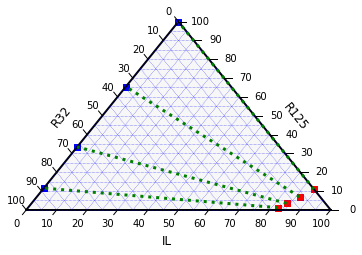

In [19]:
points_x = []

for i in range(0,4): #to shift how points are printed, shift the order
    points = (IL_x[i]*100, R125_x[i]*100, R32_x[i]*100)
    points_x.append(points)

points_y = []

for i in range(0,4): #to shift how points are printed, shift the order
    points = (IL_y[i]*100, R125_y[i]*100, R32_y[i]*100)
    points_y.append(points)

import ternary

scale = 100
figure, tax = ternary.figure(scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)

# Set Axis labels and Title
fontsize = 12
offset = 0.14
# tax.set_title("Ternary phase diagram 8 bar\n", fontsize=24)
tax.left_axis_label("R32", fontsize=fontsize, offset=offset)
tax.right_axis_label("R125", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("IL", fontsize=fontsize, offset=offset)

#for pressure changing plot would need to draw line between x[0] and x[final] for the indivual pressure
#use tax.line with the tax.scatter below
for i in range(4):
    tax.line(points_x[i], points_y[i], linewidth=3., color='green', linestyle=":")

# make this tax.line
tax.scatter(points_x, marker='s', color='red', label="liquid")
#Comment out for pressure changing plot
tax.scatter(points_y, marker='s', color='blue', label="vapor")


tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()